In [1]:
import sys, os
from time import sleep, time
import numpy as np
codebase_dir = 'D:/ZiaLab/Codebase/'
sys.path.append(codebase_dir)
%reload_ext autoreload
%autoreload 2
%load_ext autotime
from zialab.misc.sugar import send_message
from zialab.misc.sugar import ding
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pickle
data_dir = '\\\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data'
from zialab.misc.sugar import send_message, send_image, post_message_to_slack, post_file_to_slack
from collections import OrderedDict
graphs_dir = '\\\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Graphs/'
from zialab.instruments.remoteVerdi import RemoteVerdi

time: 578 ms (started: 2022-03-13 19:16:43 -04:00)


In [2]:
import io
def send_fig(fig, slack_channel, info_msg, shortfname):
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    _ = post_file_to_slack(info_msg, shortfname, buf.read(), slack_channel=slack_channel)

time: 0 ns (started: 2022-03-13 19:16:54 -04:00)


## Functions

In [ ]:
import re 
resolutions = { # for IsoPlane
    'proem': {
        '150':[[10,20,25,50,100,150,200,300],
               [0.553,0.553,0.553,0.9875,1.975,2.9625,3.95,5.925]],
        '300':[[10,20,25,50,100,150,200,300],
               [0.2734,0.2734,0.2734,0.4883,0.9765,1.4648,1.953,2.9295]],
        '50':[[10,20,25,50,100,150,200,300],
               [1.6691,1.6691,1.6691,2.9805,5.961,8.9415,11.922,17.8831]],
    },
    'pixis': {
        '50':[[10,20,25,50,100,150,200,300],
               [1.74,1.74,1.74,2.98,5.96,8.94,11.92,17.88]],
        '150':[[10,20,25,50,100,150,200,300],
               [0.58,0.58,0.58,0.98,1.98,2.96,3.95,5.93]],
        '300':[[10,20,25,50,100,150,200,300],
               [0.28,0.28,0.28,0.49,0.98,1.46,1.95,2.93]]
    },
    'pionir': {
        '50':[[10,20,25,50,100,150,200,300],
               [1.67,1.67,1.67,2.98,5.96,8.94,11.92,17.88]],
        '150':[[10,20,25,50,100,150,200,300],
               [0.55,0.55,0.55,0.98,1.98,2.96,3.95,5.93]],
        '300':[[10,20,25,50,100,150,200,300],
               [0.27,0.27,0.27,0.49,0.98,1.46,1.95,2.93]]
    },
}

def slit_to_resolution(grating, slit_width, camera):
    grating_string = re.sub("[^0-9]", "", str(grating))
    if grating_string not in ['50','150','300']:
        print("Unavailable grating")
        return None
    camera = camera.lower()
    if 'pixis' in camera:
        camera = 'pixis'
    elif 'proem' in camera:
        camera = 'proem'
    elif 'pionir' in camera:
        camera = 'pionir'
    else:
        print("invalid camera choice")
        return None
    return np.interp(slit_width,resolutions[camera][grating_string][0],resolutions[camera][grating_string][1])

time: 0 ns (started: 2022-03-13 19:55:27 -04:00)


## Initialize instruments

In [3]:
laser = RemoteVerdi()

time: 0 ns (started: 2022-03-13 19:17:04 -04:00)


## IR Spectra

### Loading lightfield

In [56]:
from zialab.softwarecontrol import lightfield
from zialab.softwarecontrol import spe2py

time: 0 ns (started: 2022-03-16 15:04:35 -04:00)


In [57]:
lf = lightfield.LField()
lf_dir = lf.lf_dir

time: 43.4 s (started: 2022-03-16 15:04:36 -04:00)


In [13]:
lf.pref_naming_settings()

time: 15 ms (started: 2022-03-13 19:24:58 -04:00)


### Spectra for sample 20D (undoped YSO) big range - FilterCube-2 - Low Gain

In [146]:
def send_fig(fig, slack_channel, info_msg, shortfname):
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    _ = post_file_to_slack(info_msg, shortfname, buf.read(), slack_channel=slack_channel)

time: 0 ns (started: 2022-03-17 10:38:08 -04:00)


> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 600000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/1
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
> Closing the laser shutter
> Calculating stats ...
> Making figure ...


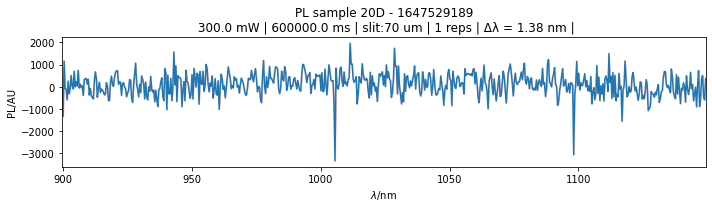

> Saving to pickle PL sample 20D - 1647529189.pkl ...
PL sample 20D - batch - 1647529189.pkl
time: 20min 18s (started: 2022-03-17 10:39:32 -04:00)


In [147]:
spectra_batch = {}
sleep(10)
for center_wave in [1025]:
    spectrum = {'sample_name': 'PL sample 20D',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'excitation_filter':'FF01-543',
            'dichroic_mirror':'FF665-Di02',
            'emission_filter':'NF03-532E'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 300/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 600*1000,
            'repeats': 1,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-not-good',
            'comments': '2 MHz, Low Gain'
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20D', '20D - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


### PionIR noise & background analysis

In [122]:
exposure_times = list(map(int,np.linspace(1,10000,5)))
spectra_batch = {}
for exposure_time in exposure_times:
    spectrum = {'sample_name': 'PionIR background',
            'bkg': [],
            'ADC': '10 MHz, Low',
            'exposure_time_in_ms': exposure_time,
            'repeats': 1,
            'center_wave': 0,
            'slit_width_in_um': 10,
            'timestamp': time(),
            'comments': ''
    }
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load2D(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[exposure_time] = spectrum
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)
batch_pkl = spectrum['pkl_fname'].replace('background', 'background - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


> Configuring the spectrograph ...
>> Setting the center wavelength to 0.0
>> Setting the spectrometer slit width to 10...
>> Setting the exposure time to 1 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
> Closing the laser shutter
Repeat 1/1
> Acquiring background data ...
> Calculating stats ...
> Configuring the spectrograph ...
>> Setting the center wavelength to 0.0
>> Setting the spectrometer slit width to 10...
>> Setting the exposure time to 2500 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
> Closing the laser shutter
Repeat 1/1
> Acquiring background data ...
> Calculating stats ...
> Configuring the spectrograph ...
>> Setting the center wavelength to 0.0
>> Setting the spectrometer slit width to 10...
>> Setting the exposure time to 5000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
> Closing the laser shutter
Repeat 1/1
> Acquiring backgr

In [123]:
batch_pkl

'PionIR background - batch - 1647527004.pkl'

time: 0 ns (started: 2022-03-17 10:23:34 -04:00)


In [124]:
pickles = {
(2, 'High'): 'PionIR background - batch - 1647526498.pkl',
(5, 'High'): 'PionIR background - batch - 1647526656.pkl',
(10, 'High'): 'PionIR background - batch - 1647526728.pkl',
(2, 'Low'): 'PionIR background - batch - 1647526792.pkl',
(5, 'Low'): 'PionIR background - batch - 1647526891.pkl',
(10, 'Low'): 'PionIR background - batch - 1647527004.pkl'
}

time: 0 ns (started: 2022-03-17 10:23:40 -04:00)


In [125]:
# plt.figure(figsize=(10,4))
# for exposure_time in spectra_batch:
#     plt.hist(spectra_batch[exposure_time]['bkg'][0][1].flatten(), bins=100)
# plt.xlim(0,30000)
# plt.show()

time: 0 ns (started: 2022-03-17 10:23:43 -04:00)


In [ ]:
spectra_batch = pickle.load( open(os.path.join(data_dir, pkl_name),'rb') )
stats = [(exptime, np.mean(spectra_batch[exptime]['bkg'][0][1].flatten())) for exptime in spectra_batch]
stats = np.array(stats)

In [128]:
noise_stats = {}
for config in pickles:
    pkl_name = pickles[config]
    spectra_batch = pickle.load( open(os.path.join(data_dir, pkl_name),'rb') )
    stats = [(exptime, np.mean(spectra_batch[exptime]['bkg'][0][1].flatten())) for exptime in spectra_batch]
    stats = np.array(stats)
    noise_stats[config] = stats

time: 6.81 s (started: 2022-03-17 10:26:17 -04:00)


(2, 'High') 0.4554 * t + 10381
t50000 = 87 s
(5, 'High') 0.4663 * t + 10785
t50000 = 84 s
(10, 'High') 0.4802 * t + 11706
t50000 = 79 s
(2, 'Low') 0.0589 * t + 10094
t50000 = 677 s
(5, 'Low') 0.0590 * t + 10375
t50000 = 671 s
(10, 'Low') 0.0605 * t + 10868
t50000 = 647 s


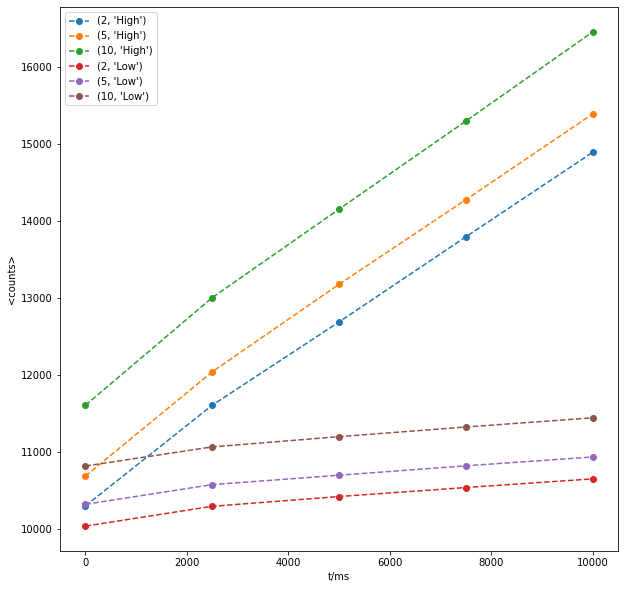

time: 453 ms (started: 2022-03-17 10:36:27 -04:00)


In [145]:

plt.figure(figsize=(10,10))
for config in noise_stats:
    stats = noise_stats[config]
    x, y = stats[:,0], stats[:,1]
    plt.plot(stats[:,0],stats[:,1],'o--', label = str(config))
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    print(config, '%.4f * t + %d' % (m,c))
    print('t50000 = %d s' %  ((50000-c)/m/1000))
plt.xlabel('t/ms')
plt.ylabel('<counts>')
plt.legend()
plt.show()

### Spectra for sample 20D (undoped YSO) big range - FilterCube-2

In [66]:
def send_fig(fig, slack_channel, info_msg, shortfname):
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    _ = post_file_to_slack(info_msg, shortfname, buf.read(), slack_channel=slack_channel)

time: 15 ms (started: 2022-03-16 16:17:54 -04:00)


> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closing the laser shutter
> Acquiring background data ...
> 

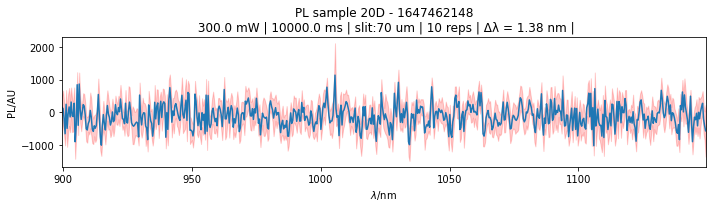

> Saving to pickle PL sample 20D - 1647462148.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closin

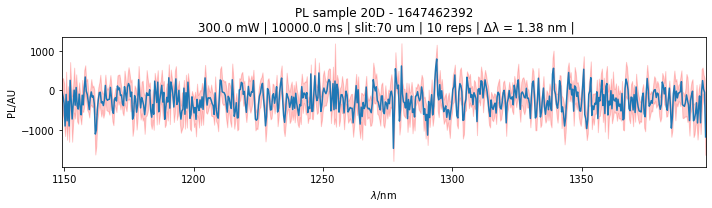

> Saving to pickle PL sample 20D - 1647462392.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closin

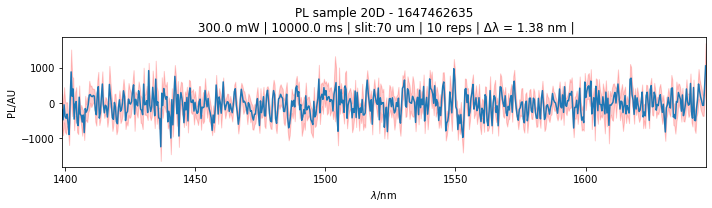

> Saving to pickle PL sample 20D - 1647462635.pkl ...
PL sample 20D - batch - 1647462635.pkl
time: 12min 25s (started: 2022-03-16 16:18:12 -04:00)


In [67]:
spectra_batch = {}
sleep(10)
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20D',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'excitation_filter':'FF01-543',
            'dichroic_mirror':'FF665-Di02',
            'emission_filter':'NF03-532E'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 300/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 10,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-not-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20D', '20D - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/30
> Closing the laser shutter
> Acquiring background data ...
> 

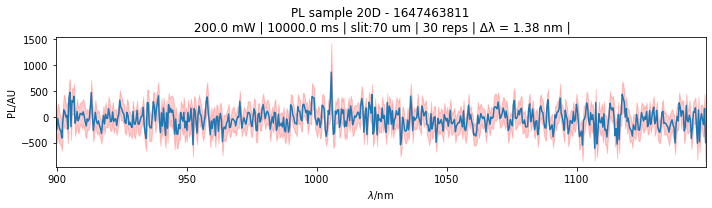

> Saving to pickle PL sample 20D - 1647463811.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/30
> Closin

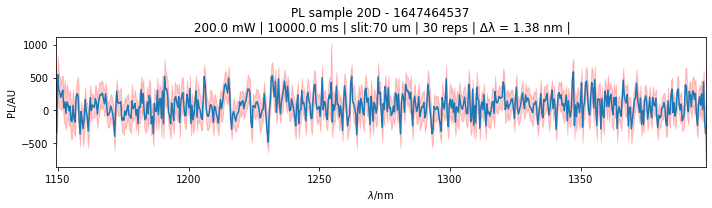

> Saving to pickle PL sample 20D - 1647464537.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/30
> Closin

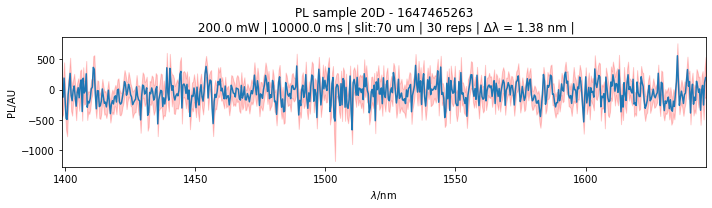

> Saving to pickle PL sample 20D - 1647465263.pkl ...
PL sample 20D - batch - 1647465263.pkl
time: 36min 19s (started: 2022-03-16 16:38:06 -04:00)


In [68]:
spectra_batch = {}
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20D',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'excitation_filter':'FF01-543',
            'dichroic_mirror':'FF665-Di02',
            'emission_filter':'NF03-532E'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 30,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-not-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20D', '20D - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


> Setting the nominal laser power to 50.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closing the laser shutter
> Acquiring background data ...
> O

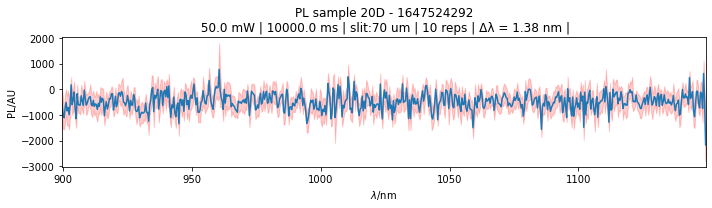

> Saving to pickle PL sample 20D - 1647524292.pkl ...
> Setting the nominal laser power to 50.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closing

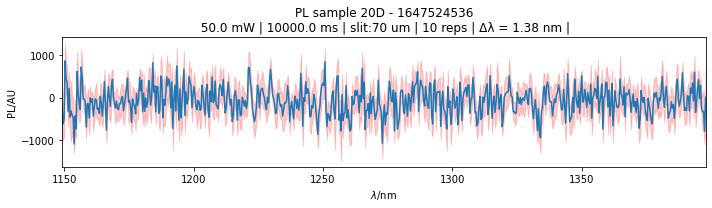

> Saving to pickle PL sample 20D - 1647524536.pkl ...
> Setting the nominal laser power to 50.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closing

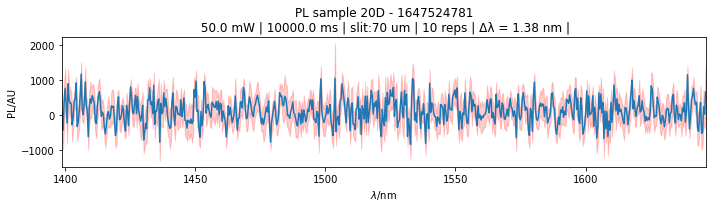

> Saving to pickle PL sample 20D - 1647524781.pkl ...
PL sample 20D - batch - 1647524781.pkl
time: 12min 15s (started: 2022-03-17 09:34:07 -04:00)


In [69]:
spectra_batch = {}
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20D',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'excitation_filter':'FF01-543',
            'dichroic_mirror':'FF665-Di02',
            'emission_filter':'NF03-532E'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 50/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 10,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-not-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20D', '20D - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


### Spectra for sample 20A (undoped YAG) big range - FilterCube-2

In [64]:
def send_fig(fig, slack_channel, info_msg, shortfname):
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    _ = post_file_to_slack(info_msg, shortfname, buf.read(), slack_channel=slack_channel)

time: 0 ns (started: 2022-03-16 16:02:14 -04:00)


> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closing the laser shutter
> Acquiring background data ...
> 

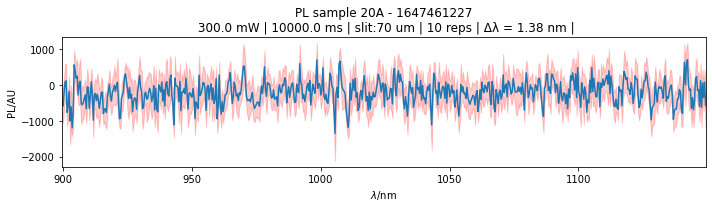

> Saving to pickle PL sample 20A - 1647461227.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closin

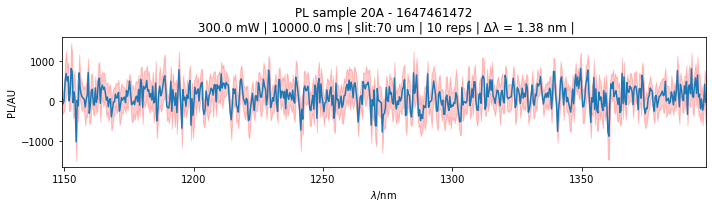

> Saving to pickle PL sample 20A - 1647461472.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closin

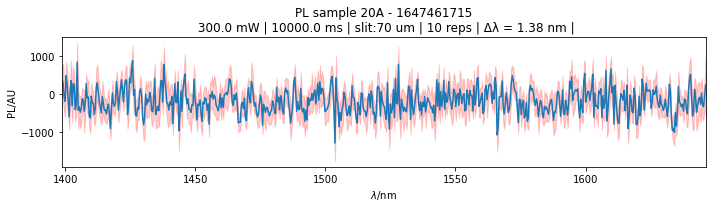

> Saving to pickle PL sample 20A - 1647461715.pkl ...
PL sample 20A - batch - 1647461715.pkl
time: 12min 23s (started: 2022-03-16 16:02:54 -04:00)


In [65]:
spectra_batch = {}
sleep(10)
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20A',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'excitation_filter':'FF01-543',
            'dichroic_mirror':'FF665-Di02',
            'emission_filter':'NF03-532E'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 300/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 10,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-not-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20A', '20A - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


### Spectra for sample 20B (undoped YAG) big range - FilterCube-2

In [62]:
def send_fig(fig, slack_channel, info_msg, shortfname):
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    _ = post_file_to_slack(info_msg, shortfname, buf.read(), slack_channel=slack_channel)

time: 0 ns (started: 2022-03-16 15:46:17 -04:00)


> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closing the laser shutter
> Acquiring background data ...
> 

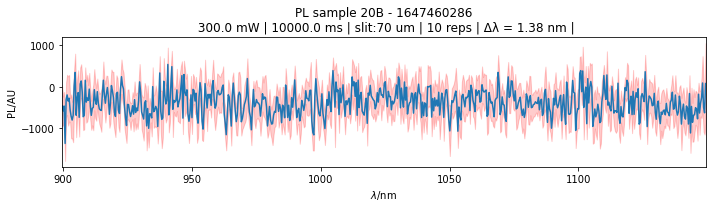

> Saving to pickle PL sample 20B - 1647460286.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closin

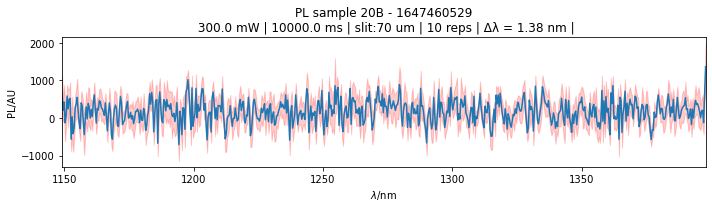

> Saving to pickle PL sample 20B - 1647460529.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closin

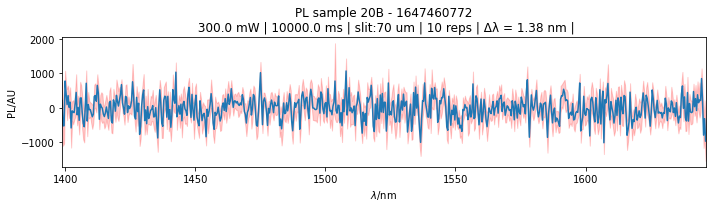

> Saving to pickle PL sample 20B - 1647460772.pkl ...
PL sample 20B - batch - 1647460772.pkl
time: 12min 37s (started: 2022-03-16 15:46:57 -04:00)


In [63]:
spectra_batch = {}
sleep(10)
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20B',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'excitation_filter':'FF01-543',
            'dichroic_mirror':'FF665-Di02',
            'emission_filter':'NF03-532E'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 300/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 10,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-not-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20B', '20B - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


### Spectra for sample 20C (undoped YAlO) big range - FilterCube-2

In [60]:
def send_fig(fig, slack_channel, info_msg, shortfname):
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    _ = post_file_to_slack(info_msg, shortfname, buf.read(), slack_channel=slack_channel)

time: 0 ns (started: 2022-03-16 15:07:33 -04:00)


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closing the laser shutter
> Acquiring background data ...
> 

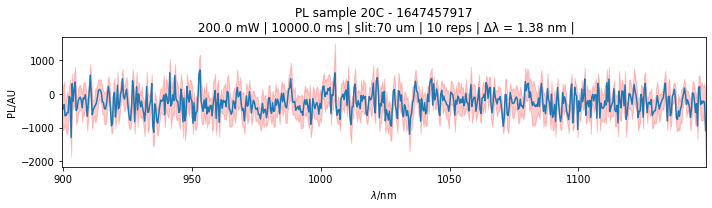

> Saving to pickle PL sample 20C - 1647457917.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closin

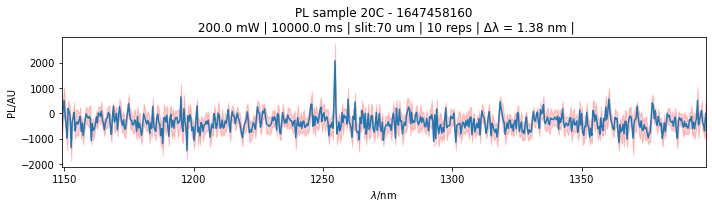

> Saving to pickle PL sample 20C - 1647458160.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closin

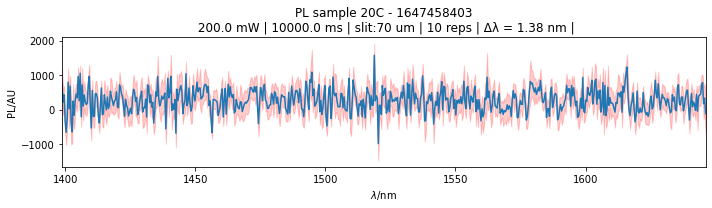

> Saving to pickle PL sample 20C - 1647458403.pkl ...
PL sample 20C - batch - 1647458403.pkl
time: 12min 22s (started: 2022-03-16 15:07:43 -04:00)


In [61]:
spectra_batch = {}
sleep(10)
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20C',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'excitation_filter':'FF01-543',
            'dichroic_mirror':'FF665-Di02',
            'emission_filter':'NF03-532E'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 10,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-not-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20C', '20C - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


### Spectra for sample 20C (undoped YAlO) big range

In [48]:
def send_fig(fig, slack_channel, info_msg, shortfname):
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    _ = post_file_to_slack(info_msg, shortfname, buf.read(), slack_channel=slack_channel)

time: 0 ns (started: 2022-03-15 12:42:58 -04:00)


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing the laser shutter
> Acquiring background data ...
> 

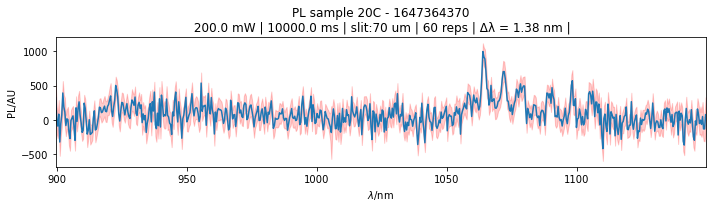

> Saving to pickle PL sample 20C - 1647364370.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closin

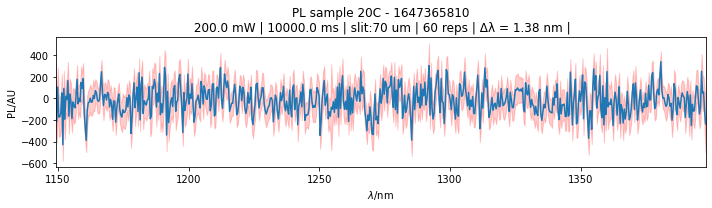

> Saving to pickle PL sample 20C - 1647365810.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closin

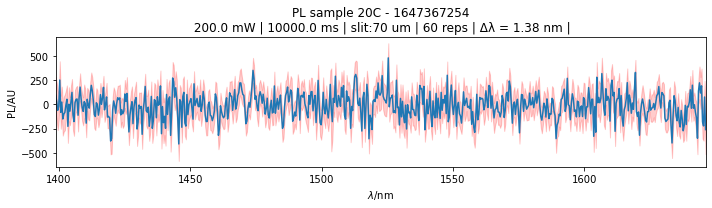

> Saving to pickle PL sample 20C - 1647367254.pkl ...
PL sample 20C - batch - 1647367254.pkl
time: 1h 12min 14s (started: 2022-03-15 12:48:42 -04:00)


In [51]:
spectra_batch = {}
sleep(10)
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20C',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 60,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20C', '20C - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1064.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/100
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/100
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/100
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/100
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/100
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/100
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/100
> Closing the laser shutter
> Acquiring background data

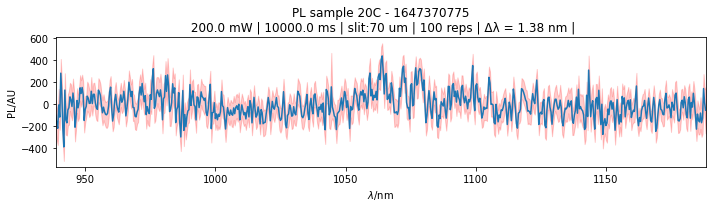

> Saving to pickle PL sample 20C - 1647370775.pkl ...
PL sample 20C - batch - 1647370775.pkl
time: 40min 15s (started: 2022-03-15 14:19:21 -04:00)


In [52]:
spectra_batch = {}
sleep(10)
for center_wave in [1064]:
    spectrum = {'sample_name': 'PL sample 20C',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 100,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-not-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20C', '20C - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 532.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/50
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/50
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/50
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/50
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/50
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/50
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/50
> Closing the laser shutter
> Acquiring background data ...
> O

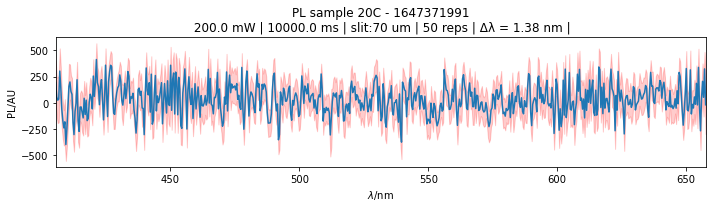

> Saving to pickle PL sample 20C - 1647371991.pkl ...
PL sample 20C - batch - 1647371991.pkl
time: 20min 15s (started: 2022-03-15 14:59:38 -04:00)


In [53]:
spectra_batch = {}
sleep(10)
for center_wave in [532]:
    spectrum = {'sample_name': 'PL sample 20C',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 50,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-not-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20C', '20C - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


In [ ]:
spectra_batch = {}
sleep(10)
for center_wave in [1064]:
    spectrum = {'sample_name': 'PL sample 20C',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 50,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-not-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20C', '20C - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


### Spectra for sample 20B (undoped YAG) big range

In [43]:
def send_fig(fig, slack_channel, info_msg, shortfname):
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    _ = post_file_to_slack(info_msg, shortfname, buf.read(), slack_channel=slack_channel)

time: 0 ns (started: 2022-03-15 09:24:12 -04:00)


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closing the laser shutter
> Acquiring background data ...
> 

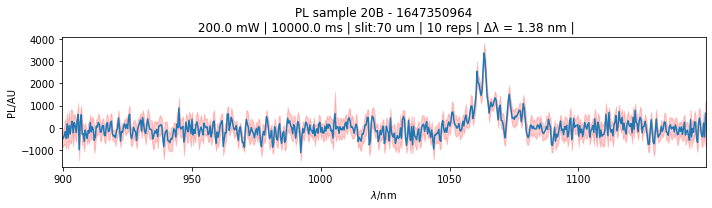

> Saving to pickle PL sample 20B - 1647350964.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closin

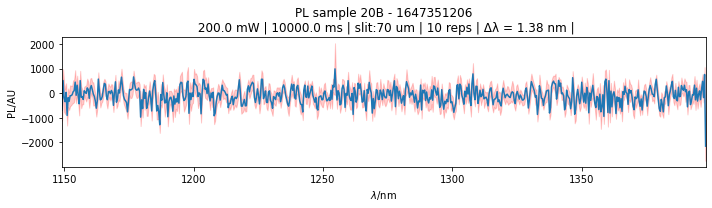

> Saving to pickle PL sample 20B - 1647351206.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/10
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/10
> Closin

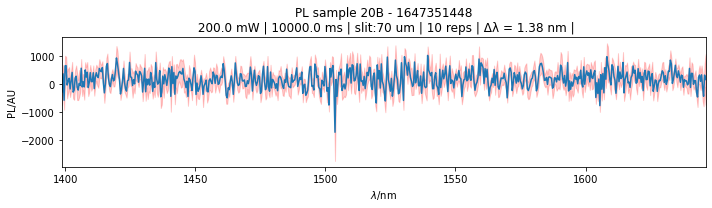

> Saving to pickle PL sample 20B - 1647351448.pkl ...
PL sample 20B - batch - 1647351448.pkl
time: 12min 8s (started: 2022-03-15 09:25:22 -04:00)


In [44]:
spectra_batch = {}
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20B',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 10,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig,'#confock', spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20B', '20B - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/30
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/30
> Closing the laser shutter
> Acquiring background data ...
> 

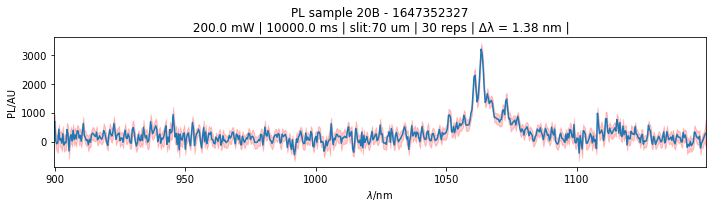

> Saving to pickle PL sample 20B - 1647352327.pkl ...
PL sample 20B - batch - 1647352327.pkl
time: 12min (started: 2022-03-15 09:40:09 -04:00)


In [45]:
spectra_batch = {}
for center_wave in [1025]:
    spectrum = {'sample_name': 'PL sample 20B',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 30,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20B', '20B - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing the laser shutter
> Acquiring background data ...
> 

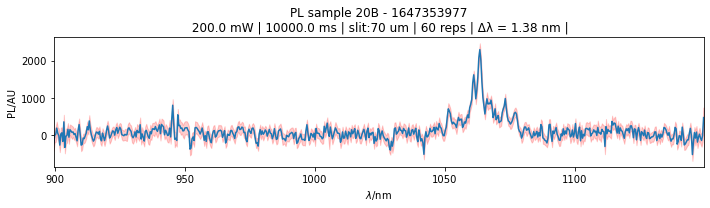

> Saving to pickle PL sample 20B - 1647353977.pkl ...
PL sample 20B - batch - 1647353977.pkl
time: 23min 56s (started: 2022-03-15 09:55:43 -04:00)


In [46]:
spectra_batch = {}
for center_wave in [1025]:
    spectrum = {'sample_name': 'PL sample 20B',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 60,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20B', '20B - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing the laser shutter
> Acquiring background data ...
> 

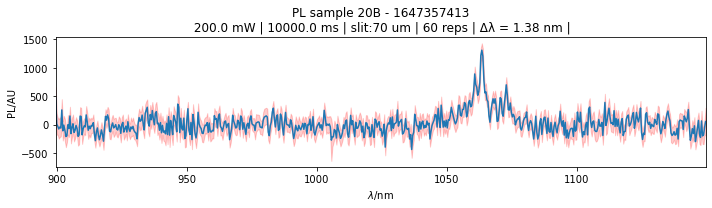

> Saving to pickle PL sample 20B - 1647357413.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closin

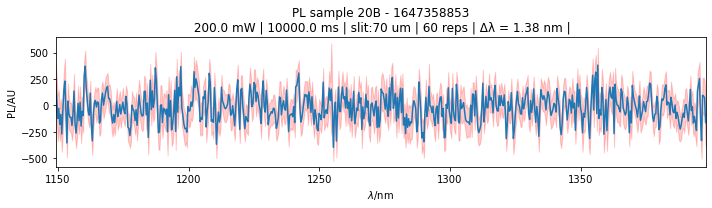

> Saving to pickle PL sample 20B - 1647358853.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 10000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closin

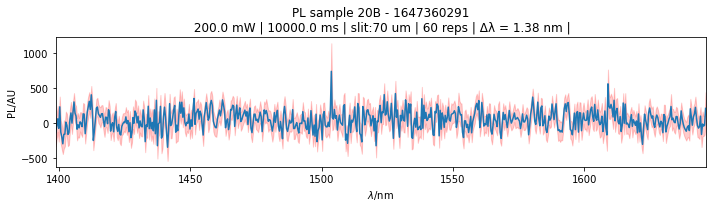

> Saving to pickle PL sample 20B - 1647360291.pkl ...
PL sample 20B - batch - 1647360291.pkl
time: 1h 11min 54s (started: 2022-03-15 10:52:58 -04:00)


In [47]:
spectra_batch = {}
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20B',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 10000,
            'repeats': 60,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'slack_channel': '#defects-are-good',
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig, spectrum['slack_channel'], spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20B', '20B - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


### Spectra for sample 20D (undoped YSO) big range - repeat with better focus

In [14]:
def send_fig(fig, slack_channel, info_msg, shortfname):
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    _ = post_file_to_slack(info_msg, shortfname, buf.read(), slack_channel=slack_channel)

time: 0 ns (started: 2022-03-13 19:25:01 -04:00)


> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 75...
>> Setting the exposure time to 5000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/20
> Closing the laser shutter
> Acquiring background data ...
> O

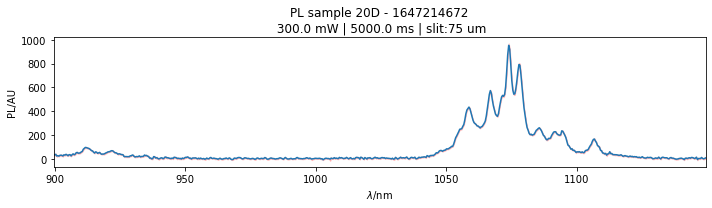

> Saving to pickle PL sample 20D - 1647214672.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 75...
>> Setting the exposure time to 5000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/20
> Closing

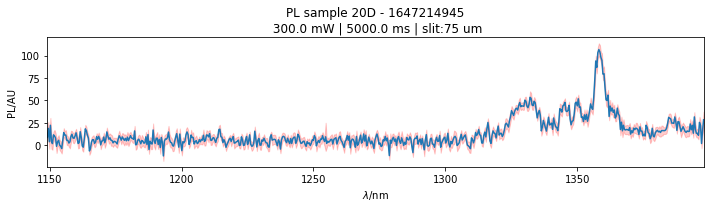

> Saving to pickle PL sample 20D - 1647214945.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 75...
>> Setting the exposure time to 5000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/20
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/20
> Closing

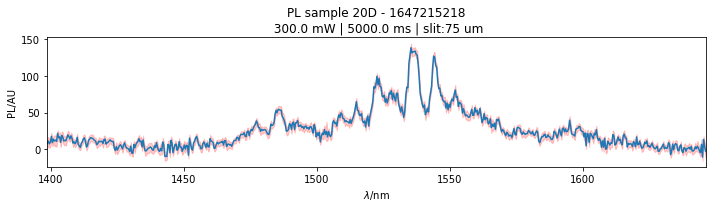

> Saving to pickle PL sample 20D - 1647215218.pkl ...
PL sample 20D - batch - 1647215218.pkl
time: 13min 40s (started: 2022-03-13 19:33:19 -04:00)


In [24]:
spectra_batch = {}
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20D',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 300/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 5000,
            'repeats': 20,
            'center_wave': center_wave,
            'slit_width_in_um': 75,
            'timestamp': time(),
            'comments': ''
    }

    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig,'#confock', spectrum['info_title'], spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20D', '20D - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


In [27]:
from zialab.misc import slit_to_resolution

ImportError: cannot import name 'slit_to_resolution' from 'zialab.misc' (D:/ZiaLab/Codebase\zialab\misc\__init__.py)

time: 16 ms (started: 2022-03-13 19:54:43 -04:00)


In [29]:
import re 
resolutions = { # for IsoPlane
    'proem': {
        '150':[[10,20,25,50,100,150,200,300],
               [0.553,0.553,0.553,0.9875,1.975,2.9625,3.95,5.925]],
        '300':[[10,20,25,50,100,150,200,300],
               [0.2734,0.2734,0.2734,0.4883,0.9765,1.4648,1.953,2.9295]],
        '50':[[10,20,25,50,100,150,200,300],
               [1.6691,1.6691,1.6691,2.9805,5.961,8.9415,11.922,17.8831]],
    },
    'pixis': {
        '50':[[10,20,25,50,100,150,200,300],
               [1.74,1.74,1.74,2.98,5.96,8.94,11.92,17.88]],
        '150':[[10,20,25,50,100,150,200,300],
               [0.58,0.58,0.58,0.98,1.98,2.96,3.95,5.93]],
        '300':[[10,20,25,50,100,150,200,300],
               [0.28,0.28,0.28,0.49,0.98,1.46,1.95,2.93]]
    },
    'pionir': {
        '50':[[10,20,25,50,100,150,200,300],
               [1.67,1.67,1.67,2.98,5.96,8.94,11.92,17.88]],
        '150':[[10,20,25,50,100,150,200,300],
               [0.55,0.55,0.55,0.98,1.98,2.96,3.95,5.93]],
        '300':[[10,20,25,50,100,150,200,300],
               [0.27,0.27,0.27,0.49,0.98,1.46,1.95,2.93]]
    },
}

def slit_to_resolution(grating, slit_width, camera):
    grating_string = re.sub("[^0-9]", "", str(grating))
    if grating_string not in ['50','150','300']:
        print("Unavailable grating")
        return None
    camera = camera.lower()
    if 'pixis' in camera:
        camera = 'pixis'
    elif 'proem' in camera:
        camera = 'proem'
    elif 'pionir' in camera:
        camera = 'pionir'
    else:
        print("invalid camera choice")
        return None
    return np.interp(slit_width,resolutions[camera][grating_string][0],resolutions[camera][grating_string][1])

time: 0 ns (started: 2022-03-13 19:55:27 -04:00)


> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 50...
>> Setting the exposure time to 5000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing the laser shutter
> Acquiring background data ...
> O

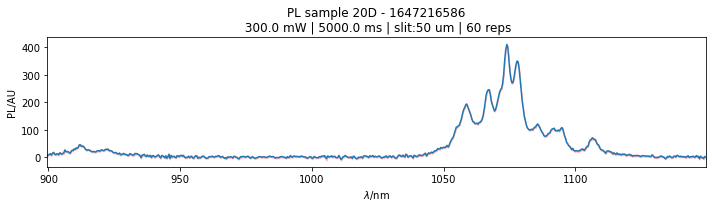

> Saving to pickle PL sample 20D - 1647216586.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 50...
>> Setting the exposure time to 5000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing

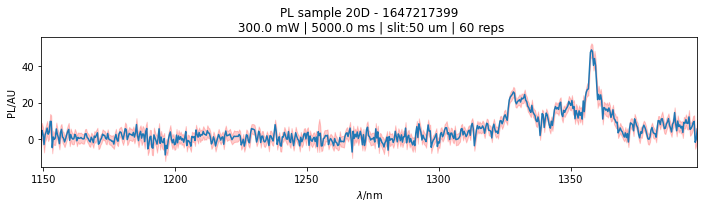

> Saving to pickle PL sample 20D - 1647217399.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 50...
>> Setting the exposure time to 5000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing

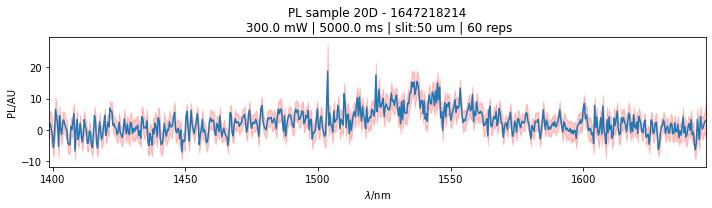

> Saving to pickle PL sample 20D - 1647218214.pkl ...
PL sample 20D - batch - 1647218214.pkl
time: 40min 45s (started: 2022-03-13 19:56:11 -04:00)


In [33]:
spectra_batch = {}
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20D',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 300/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 5000,
            'repeats': 60,
            'center_wave': center_wave,
            'slit_width_in_um': 50,
            'timestamp': time(),
            'comments': ''
    }

    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig,'#confock', spectrum['info_title'], spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20D', '20D - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 75...
>> Setting the exposure time to 5000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing the laser shutter
> Acquiring background data ...
> O

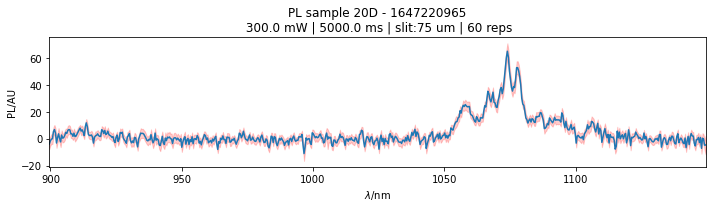

> Saving to pickle PL sample 20D - 1647220965.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 75...
>> Setting the exposure time to 5000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing

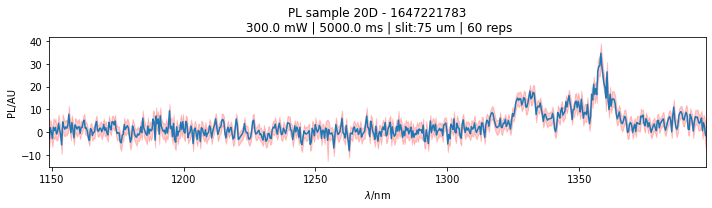

> Saving to pickle PL sample 20D - 1647221783.pkl ...
> Setting the nominal laser power to 300.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 75...
>> Setting the exposure time to 5000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing

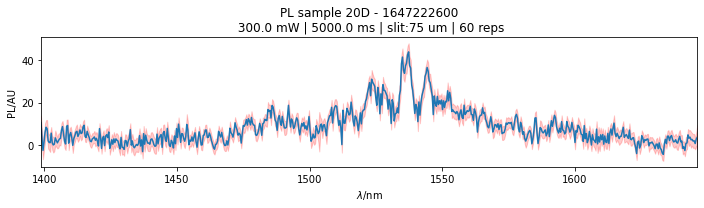

> Saving to pickle PL sample 20D - 1647222600.pkl ...
PL sample 20D - batch - 1647222600.pkl
time: 40min 54s (started: 2022-03-13 21:09:07 -04:00)


In [34]:
spectra_batch = {}
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20D',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 300/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 5000,
            'repeats': 60,
            'center_wave': center_wave,
            'slit_width_in_um': 75,
            'timestamp': time(),
            'comments': ''
    }

    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig,'#confock', spectrum['info_title'], spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20D', '20D - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 75...
>> Setting the exposure time to 7000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing the laser shutter
> Acquiring background data ...
> O

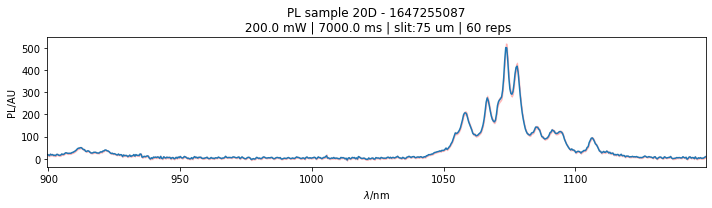

> Saving to pickle PL sample 20D - 1647255087.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 75...
>> Setting the exposure time to 7000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing

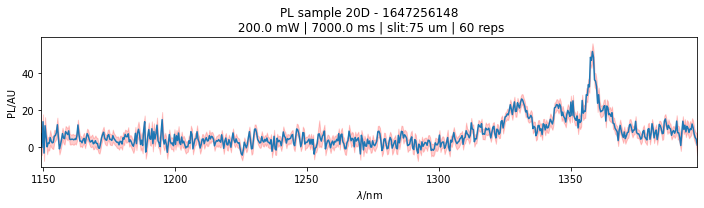

> Saving to pickle PL sample 20D - 1647256148.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 75...
>> Setting the exposure time to 7000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing

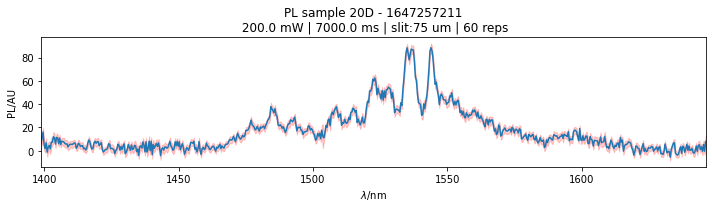

> Saving to pickle PL sample 20D - 1647257211.pkl ...
PL sample 20D - batch - 1647257211.pkl
time: 53min 4s (started: 2022-03-14 06:33:49 -04:00)


In [35]:
spectra_batch = {}
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20D',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 7000,
            'repeats': 60,
            'center_wave': center_wave,
            'slit_width_in_um': 75,
            'timestamp': time(),
            'comments': ''
    }

    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig,'#confock', spectrum['info_title'], spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20D', '20D - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))


In [39]:
slit_to_resolution('150',70,'pionir')

1.38

time: 16 ms (started: 2022-03-14 08:33:57 -04:00)


> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1025.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 8000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing the laser shutter
> Acquiring background data ...
> O

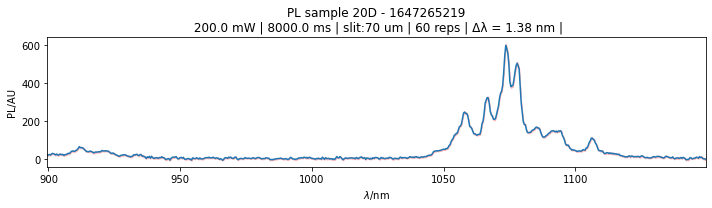

> Saving to pickle PL sample 20D - 1647265219.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1274.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 8000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing

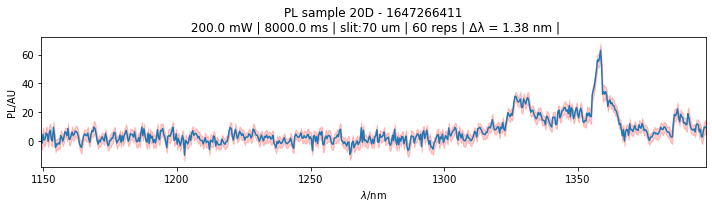

> Saving to pickle PL sample 20D - 1647266411.pkl ...
> Setting the nominal laser power to 200.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 1523.0
>> Setting the spectrometer slit width to 70...
>> Setting the exposure time to 8000 ms...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing

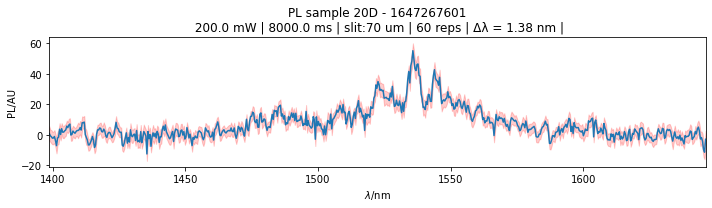

> Saving to pickle PL sample 20D - 1647267601.pkl ...
PL sample 20D - batch - 1647267601.pkl
time: 59min 32s (started: 2022-03-14 09:20:31 -04:00)


In [41]:
spectra_batch = {}
for center_wave in [1025, 1274, 1523]:
    spectrum = {'sample_name': 'PL sample 20D',
            'polarization': 'unknown',
            'optics': {'obj': '60X/0.95: Olympus',
            'laser_filter':'FF01-543/22',
            'laser_filter_2': 'LL01-532-12.5', # on the optical table
            'dichroic_mirror':'LPD01 532RS 25',
            'emission_filter':'LP03 532RS',
            'emission_filter_2':'BLP01-785R'},
            'camera': 'pionir',
            'spectrograph': 'isoplane_w',
            'grating':'150',
            'laser':{'wavelength': 532,
            'nominal_power_in_W': 200/1000.},
            'spectra': [],
            'bkg': [],
            'exposure_time_in_ms': 8000,
            'repeats': 60,
            'center_wave': center_wave,
            'slit_width_in_um': 70,
            'timestamp': time(),
            'comments': ''
    }
    spectrum['resolution'] = slit_to_resolution(spectrum['grating'],spectrum['slit_width_in_um'],spectrum['camera'])
    laser_power = spectrum['laser']['nominal_power_in_W']
    print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
    laser.set_power(laser_power)
    print("> Configuring the spectrograph ...")
    print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
    lf.set_center_wavelength(spectrum['center_wave'])
    print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
    lf.set_slit_width(spectrum['slit_width_in_um'])
    print(">> Setting the exposure time to %.0f ms..." % spectrum['exposure_time_in_ms'])
    lf.set_exposure(spectrum['exposure_time_in_ms'])
    print("> Turning off automatic background subtraction ...")
    lf.background_subraction_off()
    print("> Enforcing file-naming scheme ...")
    lf.pref_naming_settings()
    for rep in range(spectrum['repeats']):
        print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
        print("> Closing the laser shutter")
        laser.set_shutter(0)
        sleep(1)
        print("> Acquiring background data ...")
        lf.set_filename('bkg-'+spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        bkg_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['bkg'].append(bkg_data)
        print("> Opening the laser shutter ...")
        laser.set_shutter(1)
        sleep(1)
        lf.set_filename(spectrum['sample_name'])
        lf.acquire_and_wait()
        spe = lightfield.get_latest_spe_fname(lf_dir)
        pl_data = spe2py.load(spe['fname'], spe['dir'])
        spectrum['spectra'].append(pl_data)
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    print("> Calculating stats ...")
    time_finished = int(time())
    spectrum['time_finished'] = time_finished
    spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
    spectrum['signals'] = np.array(spectrum['signals'])
    spectrum['waves'] = spectrum['bkg'][0][0][:,0]
    spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
    spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

    spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
    spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
    spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
    spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

    print("> Making figure ...")
    spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um | %d reps | Δλ = %.2f nm |' % (spectrum['sample_name'], spectrum['time_finished'],
                                        1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'], spectrum['repeats'], spectrum['resolution'])
    fig = plt.figure(figsize=(10,3))
    plt.plot(spectrum['waves'], spectrum['signal_avg'])
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
    plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
    plt.title(spectrum['info_title'])
    plt.xlabel('$\lambda$/nm')
    plt.ylabel('PL/AU')
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
                transparent=True)
    plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
                transparent=False)
    send_fig(fig,'#confock', spectrum['info_title'] + (' λ = %.1f nm' % spectrum['center_wave']), spectrum['jpg_fname'])
    plt.show()

    print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
    pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
    send_message('finished %s' % spectrum['sample_name'])
    spectra_batch[center_wave] = spectrum
batch_pkl = spectrum['pkl_fname'].replace('20D', '20D - batch')
print(batch_pkl)
pickle.dump(spectra_batch, open(os.path.join(data_dir, batch_pkl),'wb'))
